# 实验 3.6 – 学员笔记本

## 概述

本实验是模块 3 引导式实验的延续。

在本实验中，您将评估在先前模块中训练的模型。您还将基于测试数据的结果计算指标。


## 业务场景简介

您在一家医疗保健服务提供商工作，并希望改善骨科患者的异常检测。

您的任务是利用机器学习 (ML) 解决此问题。您可以使用包含六个生物力学特征且目标为*正常*或*异常*的数据集。您可以使用此数据集训练 ML 模型，以预测患者是否会出现异常。


## 关于该数据集

该生物医学数据集由 Henrique da Mota 博士在法国里昂 Médico-Chirurgical de Réadaptation des Massues 中心的整形外科应用研究组 (GARO) 实习期间创建。这些数据用于两个不同但相关的分类任务。

第一项任务是将患者划分为以下三个类别： 

- *正常*（100 名患者）
- *椎间盘疝*（60 名患者）
- *脊椎滑脱*（150 名患者）

第二个任务则是将*椎间盘疝*和*脊椎滑脱*合并为一个类别，标记为*异常*。因此，在第二个任务中，患者分为两个类别：*正常*（100 名患者）或*异常*（210 名患者）。


## 属性信息

数据集中的每名患者都由六个生物力学属性表示，这些属性（顺序如下）是根据骨盆和腰椎的形状和方向得出的： 

- 骨盆入射角
- 骨盆倾斜角
- 腰椎前凸角
- 骶骨倾斜角
- 骨盆半径
- 脊椎滑脱等级

以下约定用于分类标签： 
- 椎间盘疝 (DH)
- 脊椎滑脱 (SL)
- 正常 (NO) 
- 异常 (AB)

有关此数据集的更多信息，请参阅[脊柱数据集网页](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column)。


## 数据集属性

该数据集来自：
Dua, D. 和 Graff, C.（2019 年）。UCI 机器学习存储库 (http://archive.ics.uci.edu/ml)。加州尔湾市：加利福尼亚大学信息与计算机科学学院。


# 实验设置

由于此解决方案分散在模块中的多个实验中，因此您需要运行以下单元格中的内容，以便加载数据并训练要部署的模型。

**注意**：设置过程最多可能需要 5 分钟。

## 导入数据并训练模型

通过运行以下单元格中的内容，将导入数据并让数据可供使用。

**注意**：以下单元格中的内容代表以前的实验中的关键步骤。


In [1]:
bucket='c130335a3301604l7985681t1w200712092287-labbucket-ncprzvgknmfa'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-16-18-12-22-120



2024-10-16 18:12:23 Starting - Starting the training job.
2024-10-16 18:12:37 Starting - Preparing the instances for training......
2024-10-16 18:13:08 Downloading - Downloading input data.....
2024-10-16 18:13:39 Downloading - Downloading the training image........
2024-10-16 18:14:24 Training - Training image download completed. Training in progress....
2024-10-16 18:14:45 Uploading - Uploading generated training model.
2024-10-16 18:14:58 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-16-18-14-59-229


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-16-18-14-59-862


.........................................[2024-10-16:18:21:46:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-16:18:21:46:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-16:18:21:46:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-16:18:21:46:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
    

# 步骤 1：探索结果

该模型的输出将是概率。您必须首先将概率转换为 *0* 或 *1*。您可以创建一个函数来执行转换。注意函数中阈值的使用。

In [4]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


从这些结果可以看出，初始模型可能不够好。比较几个值很难分辨。

接下来，您将生成一些指标来了解模型的性能。


# 步骤 2：创建混淆矩阵

*混淆矩阵*是衡量分类模型性能的主要方法之一。它是一张列出正确和不正确预测的表。在为模型计算混淆矩阵之后，可以生成其他一些统计数据。但在这里，您将仅先创建混淆矩阵。

要创建混淆矩阵，需要测试数据的目标值，*也*需要预测值。

从测试 DataFrame 获取目标。

In [5]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

现在，您可以使用 *scikit-learn* 库，该库包含一个创建混淆矩阵的函数。

In [6]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


不同条件下结果会有所不同，但与以下範例类似：

_ | 正常 | 异常
---------- | ----: | ----:
正常 | 7 | 3
异常 | 3 | 18



上表显示该模型正确预测了 *7 个正常*和 *18 个异常*值。但是，它错误地预测了 *3 个正常*和 *3 个异常*值。

通过使用 *seaborn* 和 *matplotlib* Python 库，您可以在图表中绘制这些值，以使其更易于阅读。

INFO:matplotlib.font_manager:generated new fontManager


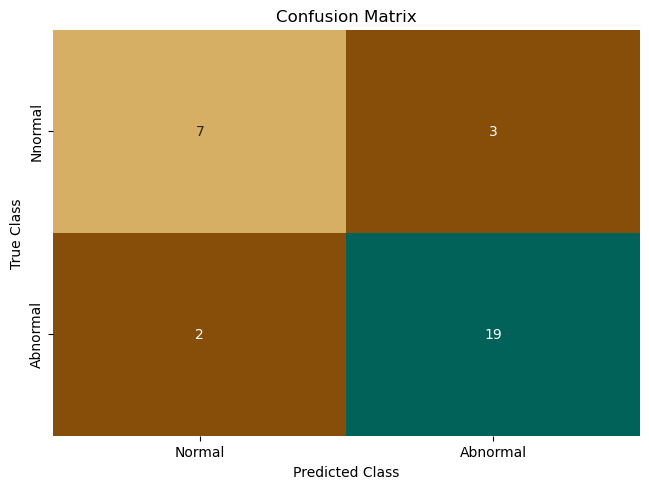

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

**提示**：如果图表首次未显示，请尝试再次运行该单元格中的内容。

如果这些结果对您的应用程序而言足够好，就表示该模型可能满足要求。但是，错误地预测*正常*值（即预测结果显示不存在异常，然后事实上却存在）会带来负面后果，因此重点应该放在减少这类结果上。

# 步骤 3：计算性能统计数据

如果要将此模型与您创建的下一个模型进行比较，则需要记录一些指标。对于二元分类问题，混淆矩阵数据可用于计算各种指标。

首先，从混淆矩阵单元中提取值到变量中。

In [8]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 2
True Positive (TP) : 19


您现在可以计算一些统计数据。


### 灵敏度

*灵敏度*也称为*命中率*、*查全率*或*真阳性率 (TPR)*。它衡量正确识别的实际阳性比例。

在该範例中，灵敏度是*检测异常患者时检测出异常的概率*。

In [9]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 90.47619047619048%
There is a 90.47619047619048% chance of detecting patients with an abnormality have an abnormality


**问题**：对于此场景而言灵敏度是否足够好？


### 特异性

下一个统计数据是*特异性*，也称为*真阴性*。它衡量正确识别的实际阴性的比例。

在该範例中，特异性是*检测正常患者时检测结果为正常的概率*。

In [10]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


**问题**：这里的特异性是太低、刚好还是太高？ 在给定的场景中，您希望看到什么样的值？



### 阳性阴性预测值

*查准率*又称*阳性预测值*，是阳性结果的比例。

在该範例中，阳性预测值是*筛查测试阳性的受试者真的存在异常的概率*。

In [11]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 86.36363636363636%
You have an abnormality, and the probablity that is correct is 86.36363636363636%


*阴性预测值*是阴性结果的比例。

在该範例中，阴性预测值是*筛查测试阴性的受试者真的不存在异常的概率*。

In [12]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 77.77777777777779%
You don't have an abnormality, but there is a 77.77777777777779% chance that is incorrect


思考这些值的影响。如果您是患者，如果异常检查为阳性，您是否应该担心？ 相反，如果测试结果为阴性，您是否应该放心？


### 假阳性率

*假阳性率 (FPR)* 是引发误报或*当真实的值为阴性时给出阳性结果的概率*。

In [13]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


### 假阴性率

*假阴性率*又称*错失率*，是*测试漏掉真正阳性的概率*。

In [14]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 9.523809523809524%
There is a 9.523809523809524% chance that this negative result is incorrect.


### 错误发现率

在该範例中，*错误发现率*是*当患者没有异常而预测存在异常的概率*。

In [15]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 13.636363636363635%
You have an abnormality, but there is a 13.636363636363635% chance this is incorrect.


### 整体准确率

您的模型有多准确？

In [16]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 83.87096774193549%


总之，您需要计算模型的以下指标：

In [17]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%


**挑战任务**：记录先前的值，然后返回到步骤 1 并更改阈值的值。您应该尝试的值为 *0.25* 和 *0.75*。

这些阈值是否会带来不同的结果？

# 步骤 4：计算 AUC-ROC 曲线

scikit-learn 库有一些函数可以帮助您计算*受试者操作特征曲线下的面积 (AUC-ROC)*。

- ROC 是概率曲线。
- AUC 表示模型对分类的区分程度。

AUC 可以通过计算得出。您将在下一个实验中看到，它可用于衡量模型的性能。

在该範例中，AUC 越高，该模型就越能够区分异常患者和正常患者。

根据您为阈值设置的值，AUC 会变化。您可以使用概率而不是转换后的分类来绘制 AUC。


In [18]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8904761904761904


通常，ROC 曲线使用 TPR 和 FPR 绘制，其中 TPR 为 y 轴，而 FPR 为 x 轴。

scikit-learn 具有 **roc_curve** 函数，有助于生成用于绘制的值。

ValueError: Axis limits cannot be NaN or Inf

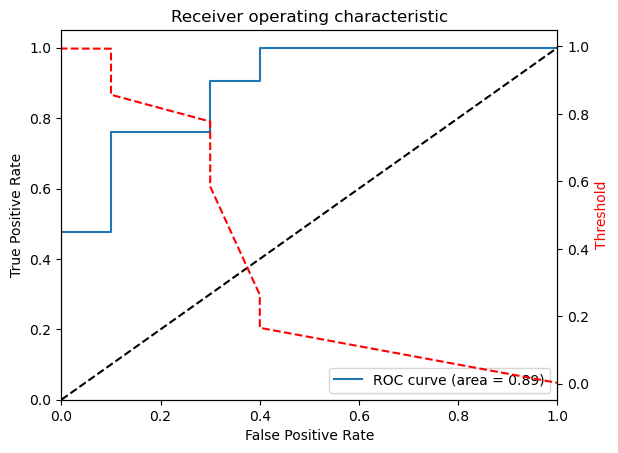

In [19]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

**挑战任务**：更新先前的代码，以使用 *target_predicted_binary* 而不是 *target_predicted*。这将如何改变该图表？ 哪个最有用？

# 恭喜！

您已经完成了本实验内容，现在可以按照实验指南中的说明结束本实验内容。

## 修正錯誤

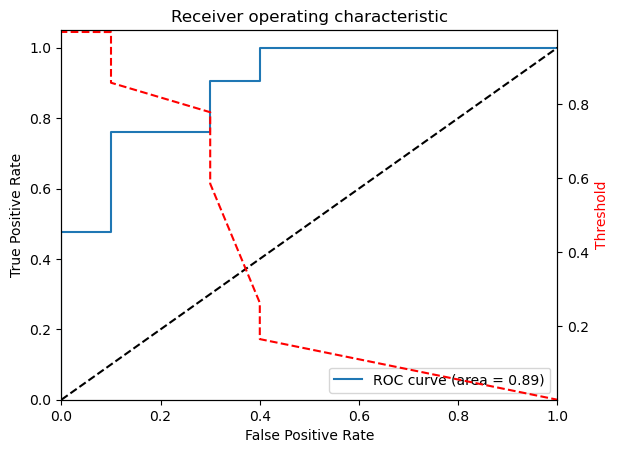

In [21]:
import numpy as np

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')

# 過濾掉 NaN 和 Inf
valid_thresholds = thresholds[np.isfinite(thresholds)]

# 確認 valid_thresholds 是非空的，且至少有一個有效值
if len(valid_thresholds) > 0:
    ax2.set_ylim([valid_thresholds[-1], valid_thresholds[0]])
else:
    print("警告：沒有有效的閾值範圍")

ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()